In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm
import glob
# direct model from google
class enhance_net_nopool(nn.Module):
    def __init__(self):
        super(enhance_net_nopool, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        n = 32
        self.e_conv1 = nn.Conv2d(3, n, 3, 1, 1)
        self.e_conv2 = nn.Conv2d(n, n, 3, 1, 1)
        self.e_conv3 = nn.Conv2d(n, n, 3, 1, 1)
        self.e_conv4 = nn.Conv2d(n, n, 3, 1, 1)
        self.e_conv5 = nn.Conv2d(n * 2, n, 3, 1, 1)
        self.e_conv6 = nn.Conv2d(n * 2, n, 3, 1, 1)
        self.e_conv7 = nn.Conv2d(n * 2, 24, 3, 1, 1)

    def forward(self, x):
        x1 = self.relu(self.e_conv1(x))
        x2 = self.relu(self.e_conv2(x1))
        x3 = self.relu(self.e_conv3(x2))
        x4 = self.relu(self.e_conv4(x3))
        x5 = self.relu(self.e_conv5(torch.cat([x3, x4], 1)))
        x6 = self.relu(self.e_conv6(torch.cat([x2, x5], 1)))
        x_r = torch.tanh(self.e_conv7(torch.cat([x1, x6], 1)))
        r1, r2, r3, r4, r5, r6, r7, r8 = torch.split(x_r, 3, dim=1)
        x = x + r1 * (x ** 2 - x)
        x = x + r2 * (x ** 2 - x)
        x = x + r3 * (x ** 2 - x)
        enhance_image_1 = x + r4 * (x ** 2 - x)
        x = enhance_image_1 + r5 * (enhance_image_1 ** 2 - enhance_image_1)
        x = x + r6 * (x ** 2 - x)
        x = x + r7 * (x ** 2 - x)
        enhance_image = x + r8 * (x ** 2 - x)
        return enhance_image
class LOLDataset(Dataset):
    def __init__(self, low_dir, high_dir):
        self.low_paths = sorted(glob.glob(os.path.join(low_dir, "*.png")))
        self.high_paths = sorted(glob.glob(os.path.join(high_dir, "*.png")))
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    def __len__(self):
        return len(self.low_paths)
    def __getitem__(self, idx):
        low = Image.open(self.low_paths[idx]).convert("RGB")
        high = Image.open(self.high_paths[idx]).convert("RGB")
        return self.transform(low), self.transform(high)
def train():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = enhance_net_nopool().to(device)
    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    dataset = LOLDataset(
        low_dir=r"C:\Users\vedhr\datasets\our485\low",
        high_dir=r"C:\Users\vedhr\datasets\our485\high")
    loader = DataLoader(dataset, batch_size=4, shuffle=True)

    for epoch in range(10):
        model.train()
        epoch_loss = 0
        for low_img, high_img in tqdm(loader, desc=f"Epoch {epoch+1}"):
            low_img, high_img = low_img.to(device), high_img.to(device)
            enhanced = model(low_img)
            loss = criterion(enhanced, high_img)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"Epoch {epoch+1} Loss: {epoch_loss:.4f}")

    torch.save(model.state_dict(), "zero_dce_trained.pth")

if __name__ == "__main__":
    train()


In [1]:
# required imports
import cv2
import torch
import numpy as np
import time
from ultralytics import YOLO
from model import enhance_net_nopool
from torchvision import transforms

start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Zero_dce fr nigh vis
enhancer = enhance_net_nopool().to(device)
enhancer.load_state_dict(torch.load("zero_dce_trained.pth", map_location=device))
enhancer.eval()

# yolov8n used
detector = YOLO("yolov8n-face.pt").to(device)
detector.fuse()

transform = transforms.ToTensor()
cap = cv2.VideoCapture(0)
startup_delay = (time.time() - start_time) * 1000
print(f"[INFO] Startup Time: {startup_delay:.2f} ms")

prev_frame_time = time.time()

def enhance_frame(frame):
    resized = cv2.resize(frame, (512, 512))
    normalized = (resized / 255.0).astype(np.float32)
    tensor = transform(normalized).unsqueeze(0).to(device)
#enhancement part
    with torch.no_grad():
        enhanced_tensor = enhancer(tensor)[0]
    enhanced_np = enhanced_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
    enhanced_np = (enhanced_np * 255).clip(0, 255).astype(np.uint8)
    sharp_kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    enhanced_np = cv2.filter2D(enhanced_np, -1, sharp_kernel)

    # scalable part
    enhanced_np = cv2.convertScaleAbs(enhanced_np, alpha=1.5, beta=40)
    return enhanced_np
while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_start = time.time()

    enhanced = enhance_frame(frame)

    # Face part
    results = detector(enhanced, verbose=False)
    faces = results[0].boxes
    if faces is not None and len(faces) > 0:
        best_face = faces.conf.argmax().item()
        xyxy = faces.xyxy[best_face].int().tolist()
        cv2.rectangle(enhanced, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (0, 255, 0), 2)
        cv2.putText(enhanced, "Face", (xyxy[0], xyxy[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)
    now = time.time()
    delay_ms = (now - frame_start) * 1000
    fps = 1 / (now - prev_frame_time)
    prev_frame_time = now
    cv2.putText(enhanced, f"FPS: {fps:.1f}", (10, 25),
                cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
    cv2.putText(enhanced, f"Delay: {delay_ms:.1f} ms", (10, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
    cv2.imshow("Original", cv2.resize(frame, (512, 512)))
    cv2.imshow("Enhanced + Detection", enhanced)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
[INFO] Startup Time: 2171.82 ms


Running on: cuda


C:\Users\vedhr\AppData\Local\Temp\ipykernel_13336\1360821129.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("8LE-color-loss2_best_model.pth", m

Startup time: 657.49 ms

- Performance Summary -
Total time: -18916.11 sec
Frames: 7166


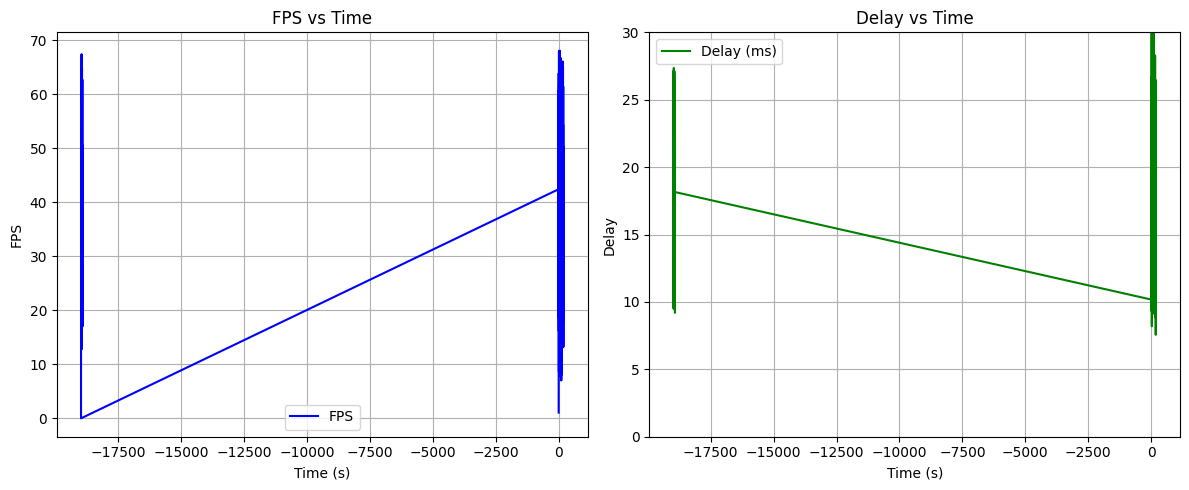

In [7]:
import os
import cv2
import time
import numpy as np
import torch
import onnxruntime as ort
from torchvision import transforms
from model import enhance_net_nopool
import matplotlib.pyplot as plt
import psutil
import GPUtil

# basic setup
start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

# load zero-dce model
enhancer = enhance_net_nopool().to(device)
checkpoint = torch.load("8LE-color-loss2_best_model.pth", map_location=device)
state_dict = checkpoint["model"]

# Rename keys: change "conv1.weight" to "e_conv1.weight", etc.
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith("conv"):
        new_k = "e_" + k
        new_state_dict[new_k] = v
    else:
        new_state_dict[k] = v

# Load the renamed state dict
enhancer.load_state_dict(new_state_dict)
enhancer.eval()

if not os.path.exists("yolov8n-face.onnx"):
    from ultralytics import YOLO
    YOLO("yolov8n-face.pt").export(format="onnx", dynamic=True, simplify=True)

# yolo onnx
providers = ["CUDAExecutionProvider"] if device.type == "cuda" else ["CPUExecutionProvider"]
yolo_sess = ort.InferenceSession("yolov8n-face.onnx", providers=providers)
yolo_input_name = yolo_sess.get_inputs()[0].name

# webcam
cap = cv2.VideoCapture(0)
print(f"Startup time: {(time.time() - start_time) * 1000:.2f} ms")

# tracking vars
transform = transforms.ToTensor()
prev_frame_time = time.time()
frame_count = 0
total_fps = 0
total_delay = 0
timestamps = []
fps_list = []
delay_list = []

def enhance_frame(frame):
    h, w = frame.shape[:2]
    frame_resized = cv2.resize(frame, (256, 256))
    norm = (frame_resized / 255.0).astype(np.float32)
    tensor = transform(norm).unsqueeze(0).to(device)

    with torch.no_grad():
        output = enhancer(tensor)[0]
    enhanced = output.squeeze(0).permute(1, 2, 0).cpu().numpy()
    enhanced = (enhanced * 255).clip(0, 255).astype(np.uint8)

    # quick sharpen + brightness
    sharpen = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    enhanced = cv2.filter2D(enhanced, -1, sharpen)
    enhanced = cv2.convertScaleAbs(enhanced, alpha=1.5, beta=40)

    return cv2.resize(enhanced, (w, h))

def run_yolo(img):
    h, w = img.shape[:2]
    img_resized = cv2.resize(img, (640, 640)).astype(np.float32) / 255.0
    input_blob = np.transpose(img_resized, (2, 0, 1))[None, ...]

    out = yolo_sess.run(None, {yolo_input_name: input_blob})[0]
    preds = np.squeeze(out).T

    confs = preds[:, 4]
    keep = confs > 0.1
    preds, confs = preds[keep], confs[keep]

    cx, cy, bw, bh = preds[:, 0], preds[:, 1], preds[:, 2], preds[:, 3]
    x1 = cx - bw / 2
    y1 = cy - bh / 2

    scale_x, scale_y = w / 640.0, h / 640.0
    boxes = [[int(x * scale_x), int(y * scale_y), int(bw_ * scale_x), int(bh_ * scale_y)]
             for x, y, bw_, bh_ in zip(x1, y1, bw, bh)]

    final = []
    if boxes:
        idxs = cv2.dnn.NMSBoxes(boxes, confs.tolist(), 0.1, 0.1)
        for i in idxs:
            x, y, bw_, bh_ = boxes[i]
            final.append((x, y, x + bw_, y + bh_, float(confs[i])))

    return final

# main loop
while True:
    ret, frame = cap.read()
    if not ret:
        break

    t0 = time.time()
    enhanced = enhance_frame(frame)
    boxes = run_yolo(enhanced)

    if boxes:
        x1, y1, x2, y2, conf = max(boxes, key=lambda b: b[4])
        cv2.rectangle(enhanced, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(enhanced, f"Face {conf:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    t1 = time.time()
    delay = (t1 - t0) * 1000
    fps = 1 / (t1 - prev_frame_time)
    prev_frame_time = t1

    frame_count += 1
    total_fps += fps
    total_delay += delay
    fps_list.append(fps)
    delay_list.append(delay)
    timestamps.append(t1 - start_time)

    cv2.putText(enhanced, f"FPS: {fps:.1f}", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
    cv2.putText(enhanced, f"Delay: {delay:.1f} ms", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)

    cv2.imshow("Original", cv2.resize(frame, (512, 512)))
    cv2.imshow("Enhanced + Detection", cv2.resize(enhanced, (512, 512)))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# memory and GPU usage
mem = psutil.virtual_memory()
gpu = GPUtil.getGPUs()[0] if GPUtil.getGPUs() else None

# summary
print("\n- Performance Summary -")
import os, psutil


print(f"Total time: {time.time() - start_time:.2f} sec")
print(f"Frames: {frame_count}")
#print(f"Avg FPS: {total_fps / frame_count:.2f}")
#print(f"Avg Delay: {total_delay / frame_count:.2f} ms")
#process = psutil.Process(os.getpid())
#print(f"Script RAM Usage: {process.memory_info().rss / (1024 ** 2):.2f} MB")
#print(f"GPU Load: {f'{gpu.load*100:.1f}%' if gpu else 'N/A'}")
#print(f"GPU Mem: {f'{gpu.memoryUsed}MB / {gpu.memoryTotal}MB' if gpu else 'N/A'}")

# plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(timestamps, fps_list, color='blue', label='FPS')
plt.xlabel("Time (s)")
plt.ylabel("FPS")
plt.title("FPS vs Time")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(timestamps, delay_list, color='green', label='Delay (ms)')
plt.xlabel("Time (s)")
plt.ylabel("Delay")
plt.title("Delay vs Time")
plt.grid(True)
plt.legend()
plt.ylim(0, 30)
plt.yticks(np.arange(0, 31, 5))

plt.tight_layout()
plt.show()


Running on: cuda


C:\Users\vedhr\AppData\Local\Temp\ipykernel_13336\1106447384.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  enhancer.load_state_dict(torch.load("zero_dce_trained.pth",

Startup time: 966.70 ms

- Performance Summary -
Total time: 21.77 sec
Frames: 523
Avg FPS: 31.09
Avg Delay: 16.96 ms
Script RAM Usage: 370.36 MB
GPU Load: 0.0%
GPU Mem: 297.0MB / 8188.0MB


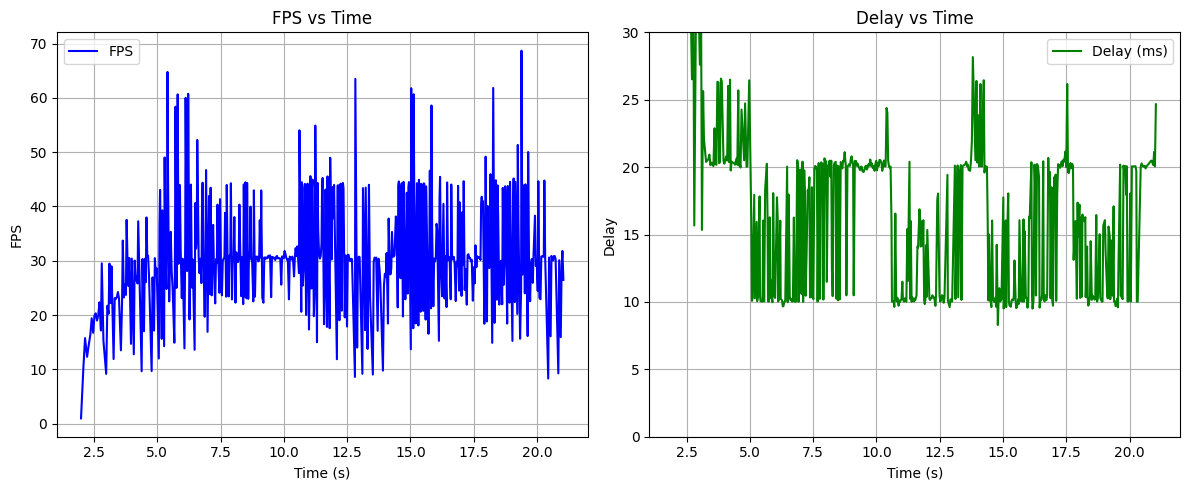

In [6]:
import os
import cv2
import time
import numpy as np
import torch
import onnxruntime as ort
from torchvision import transforms
from model import enhance_net_nopool
import matplotlib.pyplot as plt
import psutil
import GPUtil

# basic setup
start_time = time.time()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on:", device)

# load zero-dce model
enhancer = enhance_net_nopool().to(device)
enhancer.load_state_dict(torch.load("zero_dce_trained.pth", map_location=device))
enhancer.eval()

if not os.path.exists("yolov8n-face.onnx"):
    from ultralytics import YOLO
    YOLO("yolov8n-face.pt").export(format="onnx", dynamic=True, simplify=True)

# yolo onnx
providers = ["CUDAExecutionProvider"] if device.type == "cuda" else ["CPUExecutionProvider"]
yolo_sess = ort.InferenceSession("yolov8n-face.onnx", providers=providers)
yolo_input_name = yolo_sess.get_inputs()[0].name

# webcam
cap = cv2.VideoCapture(0)
print(f"Startup time: {(time.time() - start_time) * 1000:.2f} ms")

# tracking vars
transform = transforms.ToTensor()
prev_frame_time = time.time()
frame_count = 0
total_fps = 0
total_delay = 0
timestamps = []
fps_list = []
delay_list = []

def enhance_frame(frame):
    h, w = frame.shape[:2]
    frame_resized = cv2.resize(frame, (256, 256))
    norm = (frame_resized / 255.0).astype(np.float32)
    tensor = transform(norm).unsqueeze(0).to(device)

    with torch.no_grad():
        output = enhancer(tensor)[0]
    enhanced = output.squeeze(0).permute(1, 2, 0).cpu().numpy()
    enhanced = (enhanced * 255).clip(0, 255).astype(np.uint8)

    # quick sharpen + brightness
    sharpen = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    enhanced = cv2.filter2D(enhanced, -1, sharpen)
    enhanced = cv2.convertScaleAbs(enhanced, alpha=1.5, beta=40)

    return cv2.resize(enhanced, (w, h))

def run_yolo(img):
    h, w = img.shape[:2]
    img_resized = cv2.resize(img, (640, 640)).astype(np.float32) / 255.0
    input_blob = np.transpose(img_resized, (2, 0, 1))[None, ...]

    out = yolo_sess.run(None, {yolo_input_name: input_blob})[0]
    preds = np.squeeze(out).T

    confs = preds[:, 4]
    keep = confs > 0.45
    preds, confs = preds[keep], confs[keep]

    cx, cy, bw, bh = preds[:, 0], preds[:, 1], preds[:, 2], preds[:, 3]
    x1 = cx - bw / 2
    y1 = cy - bh / 2

    scale_x, scale_y = w / 640.0, h / 640.0
    boxes = [[int(x * scale_x), int(y * scale_y), int(bw_ * scale_x), int(bh_ * scale_y)]
             for x, y, bw_, bh_ in zip(x1, y1, bw, bh)]

    final = []
    if boxes:
        idxs = cv2.dnn.NMSBoxes(boxes, confs.tolist(), 0.45, 0.5)
        for i in idxs:
            x, y, bw_, bh_ = boxes[i]
            final.append((x, y, x + bw_, y + bh_, float(confs[i])))

    return final

# main loop
while True:
    ret, frame = cap.read()
    if not ret:
        break

    t0 = time.time()
    enhanced = enhance_frame(frame)
    boxes = run_yolo(enhanced)

    if boxes:
        x1, y1, x2, y2, conf = max(boxes, key=lambda b: b[4])
        cv2.rectangle(enhanced, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(enhanced, f"Face {conf:.2f}", (x1, y1 - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

    t1 = time.time()
    delay = (t1 - t0) * 1000
    fps = 1 / (t1 - prev_frame_time)
    prev_frame_time = t1

    frame_count += 1
    total_fps += fps
    total_delay += delay
    fps_list.append(fps)
    delay_list.append(delay)
    timestamps.append(t1 - start_time)
    
    cv2.putText(enhanced, f"FPS: {fps:.1f}", (10, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
    cv2.putText(enhanced, f"Delay: {delay:.1f} ms", (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 0), 2)
    
    cv2.imshow("Original", cv2.resize(frame, (512, 512)))
    cv2.imshow("Enhanced + Detection", cv2.resize(enhanced, (512, 512)))

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

# memory and GPU usage
mem = psutil.virtual_memory()
gpu = GPUtil.getGPUs()[0] if GPUtil.getGPUs() else None

# summary
print("\n- Performance Summary -")
import os, psutil


print(f"Total time: {time.time() - start_time:.2f} sec")
print(f"Frames: {frame_count}")
print(f"Avg FPS: {total_fps / frame_count:.2f}")
print(f"Avg Delay: {total_delay / frame_count:.2f} ms")
process = psutil.Process(os.getpid())
print(f"Script RAM Usage: {process.memory_info().rss / (1024 ** 2):.2f} MB")
print(f"GPU Load: {f'{gpu.load*100:.1f}%' if gpu else 'N/A'}")
print(f"GPU Mem: {f'{gpu.memoryUsed}MB / {gpu.memoryTotal}MB' if gpu else 'N/A'}")

# plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(timestamps, fps_list, color='blue', label='FPS')
plt.xlabel("Time (s)")
plt.ylabel("FPS")
plt.title("FPS vs Time")
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(timestamps, delay_list, color='green', label='Delay (ms)')
plt.xlabel("Time (s)")
plt.ylabel("Delay")
plt.title("Delay vs Time")
plt.grid(True)
plt.legend()
plt.ylim(0, 30)
plt.yticks(np.arange(0, 31, 5))

plt.tight_layout()
plt.show()


In [4]:
checkpoint = torch.load("8LE-color-loss2_best_model.pth", map_location=device)
print(checkpoint.keys())


dict_keys(['epoch', 'model', 'optimizer', 'HyperParam', 'val_loss', 'loss_history', 'model_src', 'train_src'])


C:\Users\vedhr\AppData\Local\Temp\ipykernel_13336\3650642152.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("8LE-color-loss2_best_model.pth", ma